# Prepare

For preparations I will follow a fast aproach and I will remove all columns that are not helpfull.

**import**

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spliting the data
from sklearn.model_selection import TimeSeriesSplit
from math import ceil

# system manipulation
import sys
sys.path.append("./util_")
import prepare_
import acquire_


# other
import warnings
warnings.filterwarnings("ignore")

# set a default them for all my visuals
sns.set_theme(style="whitegrid")

### get data

In [2]:
# get data from acquire file
dogs = acquire_.get_org_data()
dogs.head()

,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
UniqueID,,,,,,,,
1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


**Rename columns**

In [3]:
# make the columsn lower case
# replace spaces
dogs.columns = dogs.columns.str.lower().str.strip().str.replace("†","").str.replace(" ","_")
dogs.head(1)

,dateofbite,species,breed,age,gender,spayneuter,borough,zipcode
UniqueID,,,,,,,,
1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220


**Convert data types**

In [4]:
# view datatypes
dogs.dtypes

dateofbite    object
species       object
breed         object
age           object
gender        object
spayneuter      bool
borough       object
zipcode       object
dtype: object

In [5]:
# count the unique value counts in each column
for i in dogs.columns:
    print("_" * 20, i.upper())
    print(dogs[i].value_counts().value_counts())

____________________ DATEOFBITE
7     299
9     276
6     267
8     228
10    219
5     208
11    192
12    164
4     127
13    124
14     97
3      93
15     65
16     52
17     38
2      37
1      16
19     15
18     14
20     11
21      4
22      4
24      2
25      2
23      1
Name: dateofbite, dtype: int64
____________________ SPECIES
22663    1
Name: species, dtype: int64
____________________ BREED
1      1186
2       162
3        54
4        39
5        24
       ... 
95        1
106       1
123       1
127       1
53        1
Name: breed, Length: 89, dtype: int64
____________________ AGE
1       122
2        31
3         8
4         7
6         6
9         6
5         4
20        3
10        2
13        2
11        2
7         2
50        2
45        1
8         1
14        1
17        1
22        1
26        1
27        1
33        1
34        1
1624      1
1504      1
242       1
1365      1
1178      1
1040      1
795       1
655       1
569       1
375       1
361       1
1

In [6]:
# convert string to datetime
dogs.dateofbite = dogs.dateofbite.astype("datetime64")

**Find nulls**

In [7]:
dogs.isna().sum()

dateofbite        0
species           0
breed          2218
age           11221
gender            0
spayneuter        0
borough           0
zipcode        5858
dtype: int64

**Drop duplicate**

In [8]:
dogs.duplicated().sum(), dogs.duplicated().sum()/len(dogs)

(541, 0.023871508626395446)

In [9]:
# remove duplicated rows
dogs = dogs.drop_duplicates()

**Drop columns**

In [10]:
dogs.columns

Index(['dateofbite', 'species', 'breed', 'age', 'gender', 'spayneuter',
       'borough', 'zipcode'],
      dtype='object')

In [11]:
# extract date column and remove everything else
dogs = dogs[dogs.columns[dogs.columns.isin(["dateofbite"])]]
dogs.head()

,dateofbite
UniqueID,
1,2018-01-01
2,2018-01-04
3,2018-01-06
4,2018-01-08
5,2018-01-09


**Create my target**

In [12]:
# create my target bite column
dogs["bite"] = int(1)

In [13]:
# set the date to be the indexinf column
dogs = dogs.set_index("dateofbite").sort_index()
dogs.head(1)

,bite
dateofbite,
2015-01-01,1


**Frequency of time**

In [14]:
# occurrences of each date
dogs.index.value_counts()

2015-06-06    25
2017-09-16    25
2018-06-23    24
2018-07-04    23
2018-06-02    22
              ..
2020-05-08     1
2020-10-06     1
2021-03-02     1
2016-03-14     1
2021-12-31     1
Name: dateofbite, Length: 2555, dtype: int64

In [15]:
# occurrences of each dates occurrence
dogs.index.value_counts().value_counts()

6     289
7     286
9     275
8     248
10    227
5     224
11    196
12    147
13    126
4     126
3      99
14     88
15     56
16     39
2      38
17     34
1      16
19     12
18     11
20      8
21      3
22      3
25      2
24      1
23      1
Name: dateofbite, dtype: int64

**Check for gaps in time**

In [16]:
# earliest date
min_date = dogs.index.min()
min_date

Timestamp('2015-01-01 00:00:00')

In [17]:
# latest date
max_date = dogs.index.max()
max_date

Timestamp('2021-12-31 00:00:00')

In [18]:
#see how many unique days we actually have
dogs.shape[0], dogs.index.nunique()

# I see that I ight have missing dates or they are just duplicated dates

(22122, 2555)

**Find the missing dates**

In [19]:
#establish all the expected dates in our range
expected_date_range = pd.date_range(min_date, max_date, freq="m")
expected_date_range

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
      

In [20]:
# now how many dates are missing
len(expected_date_range.difference(dogs.index))

# I have 0 gap in my dates

0

**Engineer the target into daily bits counts**

In [21]:
# Engineer the target into daily bits counts
dogs = dogs.resample('D').sum()

In [24]:
dogs.head(3)

,bite
dateofbite,
2015-01-01,7
2015-01-02,9
2015-01-03,7


**Find seasonality in the data**

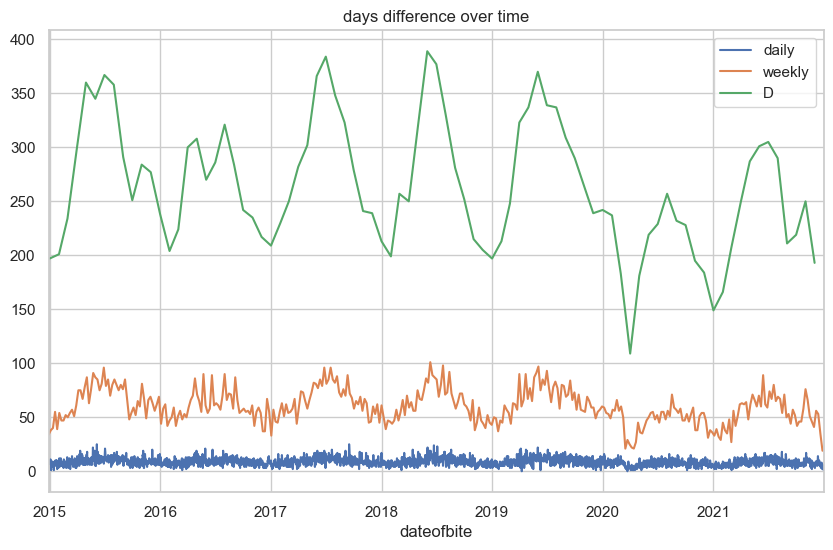

In [26]:
plt.figure(figsize=(10,6))

dogs.resample('D').sum().bite.plot(label='daily')
dogs.resample('W').sum().bite.plot(label='weekly')
dogs.resample('M').sum().bite.plot(label='D')
# dogs.resample('Y').sum().bite.plot(label='yearly')
plt.title('days difference over time')
plt.legend()

# save visual
# prepare_.save_visuals_(plt.gcf(), viz_name= "days_difference_over_time")
plt.show()


**Create a year month and day column**

In [27]:
# create a year, month, day column from the index
dogs["year"] = dogs.index.year
dogs["month"] = dogs.index.month_name()
dogs["day"] = dogs.index.day_name()

dogs["month_number"] = dogs.index.month
dogs["weekday_number"] = dogs.index.weekday

dogs.head(1)

,bite,year,month,day,month_number,weekday_number
dateofbite,,,,,,
2015-01-01,7,2015,January,Thursday,1,3


**Split data**

Use human based approach for spliting because I can see a clear seasonality in the data.

In [28]:
# split data
train = dogs[:"2018"]
validate = dogs["2019":"2020"]
test = dogs["2021":]

train.shape, validate.shape, test.shape

((1461, 6), (731, 6), (365, 6))

In [29]:
# save the split data
prepare_.save_split_data_(cleaned_data=dogs, train=train, validate=validate, test=test)

'Four data sets saved as .csv'

**Actions taken and takeaways**

- Rename columns.
- Convert data types (dateofbite).
- Drop columns (all except dateofbite).
- Drop duplicates (541, 2%).
- Set and sort date index.
- Check for gaps in time (0 days missing).
    - Erliest time (2015-01-01).
    - Latest time (2021-12-31).
- Create a dog bit target column.
    - Becas=use each row is a successfully recorded dog bite all rows are assigned to value 1.
- Use human-based splitting.
    - Because there is clear seasonality in the data.